# Projecto Bootcamp Ciencia de Datos - Código Facilito

## **Introducción**

Tenía un interés personal en investigar datos relacionados con recetas disponibles en internet y su popularidad. Para ello encontré un dataset que contenía recetas y también el tráfico que genera cada una de ellas para así poder comprobar su popularidad ya que hice la suposición de que a más tráfico más popularidad.

## **Validación de los datos**

Este conjunto de datos consta de 947 filas y 8 columnas (sería una matriz de 947x8). De las columnas existentes en el dataset y, antes de proceder con su limpieza y transformaciones, 6 son numéricas y dos son de tipo carácter/string. Tras un estudio pormenorizado, pasamos a indicar el nombre de las columnas y la limpieza y/o transformación que apliqué sobre ellas:

1. **recipe**: Es un identificador único, una primary key del dataset. Contiene 947 valores únicos, y como el dataset tiene 947 filas esto quiere decir que no es necesario limpiar esta columna ya que no contiene duplicados. El valor mínimo es 1 y el valor máximo es 947. Es de tipo integer. Dado que el índice del dataframe que construímos a partir de los datos, tiene el mismo propósito, elegí eliminar esta columna.

2. **calories, carbohydrate, sugar y protein**: Contienen 895 valores no nulos ergo, hay 52 valores nulos. Como podemos ver claramente en la matriz missingno, estos valores nulos están en las mismas filas, por lo que he decido aplicar la media de cada columna en función de la categoría de alimentos, ya que he pensado que podría enriquecer de este modo los datos faltantes en función de una característica relevante. Todas estas variables son de tipo float y ninguna de ellas tiene valores negativos, tal y como debería ser (lo contrario no tendría sentido).

3. **category**: Todas las filas de esta columna contienen valores no nulos. Ahora bién si observamos sus valores únicos, podemos ver que hay diferentes categorías para meat, chicken, chicken breast y pork. He decido transformar los tres últimos en una misma categoría: meat (carne), ya que creo que esta sería su categoría lógica. Hice lo mismo con vegetable y potato. Transformé el tipo de datos en categoría.

4. **servings**: Mi suposición es que debería ser un tipo numérico pero aparece como objeto en su lugar. Observé que hay dos valores que contienen un sufijo con la cadena o string de caracteres " as a snack". He decido eliminar esa cadena final y transformar el tipo de datos a categoría.

5. **high_traffic**: Su valor es o bién 'High' o un valor null (nulo). He decido cambiarlos a 1 y 0 para comprobar de manera más clara su distribución y poder preparar la variable para los modelos de Machine Learning. También lo he transformado un a tipo categoría.

Después de la transformación, obtendremos un dataframe de 947x7 con 4 columnas de tipo float y 3 columnas de tipo categoría (categorical) sin valores nulos.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer

# Se configura el estilo de las gráficas de Matplotlib para que siga el estilo 'ggplot'.
plt.style.use('ggplot')

# Se suprimen los FutureWarnings para mejorar la legibilidad del código.
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Cargamos el conjunto de datos desde un archivo CSV en un DataFrame llamado 'df'.
df = pd.read_csv('sample_data/data.csv')

# Se muestran las primeras filas del DataFrame para inspeccionar los datos iniciales.
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [ ]:
# Se obtiene el número de filas y columnas del DataFrame.
df.shape

(947, 8)

In [ ]:
# Información general del Dataframe. Se muestra información general sobre las columnas,
# incluyendo los tipos de datos y la presencia de valores nulos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [ ]:
# Comprobamos el número de valores únicos que contiene la columna 'recipe'.
# Se verifica que la columna 'recipe' contiene 947 valores únicos.
df['recipe'].nunique()

947

In [ ]:
# Eliminamos la columna 'recipe' ya que podemos utilizar el índice del Dataframe.
df.drop(['recipe'],axis=1, inplace=True)

In [ ]:
# La columna servings debería ser numérica, pero nos retorna que es de tipo object (dtype=object)-
# Investigamos el porqué.
df['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

In [ ]:
# Comprobamos que contiene el sufijo ' as a snack'. Eliminamos el sufijo ' as a snack' ya que no aporta nada
# y transformamos la columna via astype en un tipo categórico (category).
df['servings'] = df['servings'].str.replace(' as a snack','').astype('category')

In [ ]:
# Comprobamos cuáles son los valores únicos para la columna 'category'
df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

In [ ]:
# Agrupamos las categorías que representan carne (meat) y las que representan vegetables.
# Se observan varias categorías relacionadas con alimentos. Decidimos agrupar 'Pork',
# 'Chicken Breast', y 'Chicken' bajo la categoría 'Meat', y 'Potato' bajo la categoría 'Vegetable'.
df['category'] = df['category'].replace(['Pork','Chicken Breast','Chicken'],'Meat')
df['category'] = df['category'].replace('Potato','Vegetable')

# Transfomamos la columna 'high_traffic' como una columna categórica (categorical column).
df['category'] = df['category'].astype('category')

In [ ]:
# Utilizamos el método describe() para comprobar las variables numéricas y observamos que no contienen
# valores negativos.
df.describe()

,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296
std,453.020997,43.949032,14.679176,36.369739
min,0.140000,0.030000,0.010000,0.000000
25%,110.430000,8.375000,1.690000,3.195000
50%,288.550000,21.480000,4.550000,10.800000
75%,597.650000,44.965000,9.800000,30.200000
max,3633.160000,530.420000,148.750000,363.360000


In [ ]:
# Comprobamos los valores únicos para la columna 'high_traffic'.
# Se observa que esta columna contiene el valor 'High' y valores nulos (NaN).
df['high_traffic'].unique()

array(['High', nan], dtype=object)

In [ ]:
# Modificamos los valores de la columna 'high_traffic' de manera que los valores con el literal 'High' los
# transformamos al valor 1, y los valores nulos al valor 0.
# Finalmente modificamos la columna 'high_traffic' a un tipo categórico.
reps = {'High':1, np.nan:0}
df['high_traffic'] = df['high_traffic'].replace(reps).astype('category')

In [ ]:
# Visualizamos la distribution de los valores de la columna 'high_traffic'.
df['high_traffic'].value_counts()

1.0    574
0.0    373
Name: high_traffic, dtype: int64

In [ ]:
# Comprobamos si los valores nulos en las columnas 'calories', 'carbohydrate', 'sugar' y 'protein'
# se encuentran en las mismas filas y, vemos que se verifica que los valores nulos de estas columnas
# están en las mismas filas.
df[df['calories'].isna()].head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,NaN,NaN,NaN,NaN,Meat,6,1.0
23,NaN,NaN,NaN,NaN,Meat,2,0.0
48,NaN,NaN,NaN,NaN,Meat,4,0.0
82,NaN,NaN,NaN,NaN,Meat,4,1.0
89,NaN,NaN,NaN,NaN,Meat,6,1.0


<Axes: >

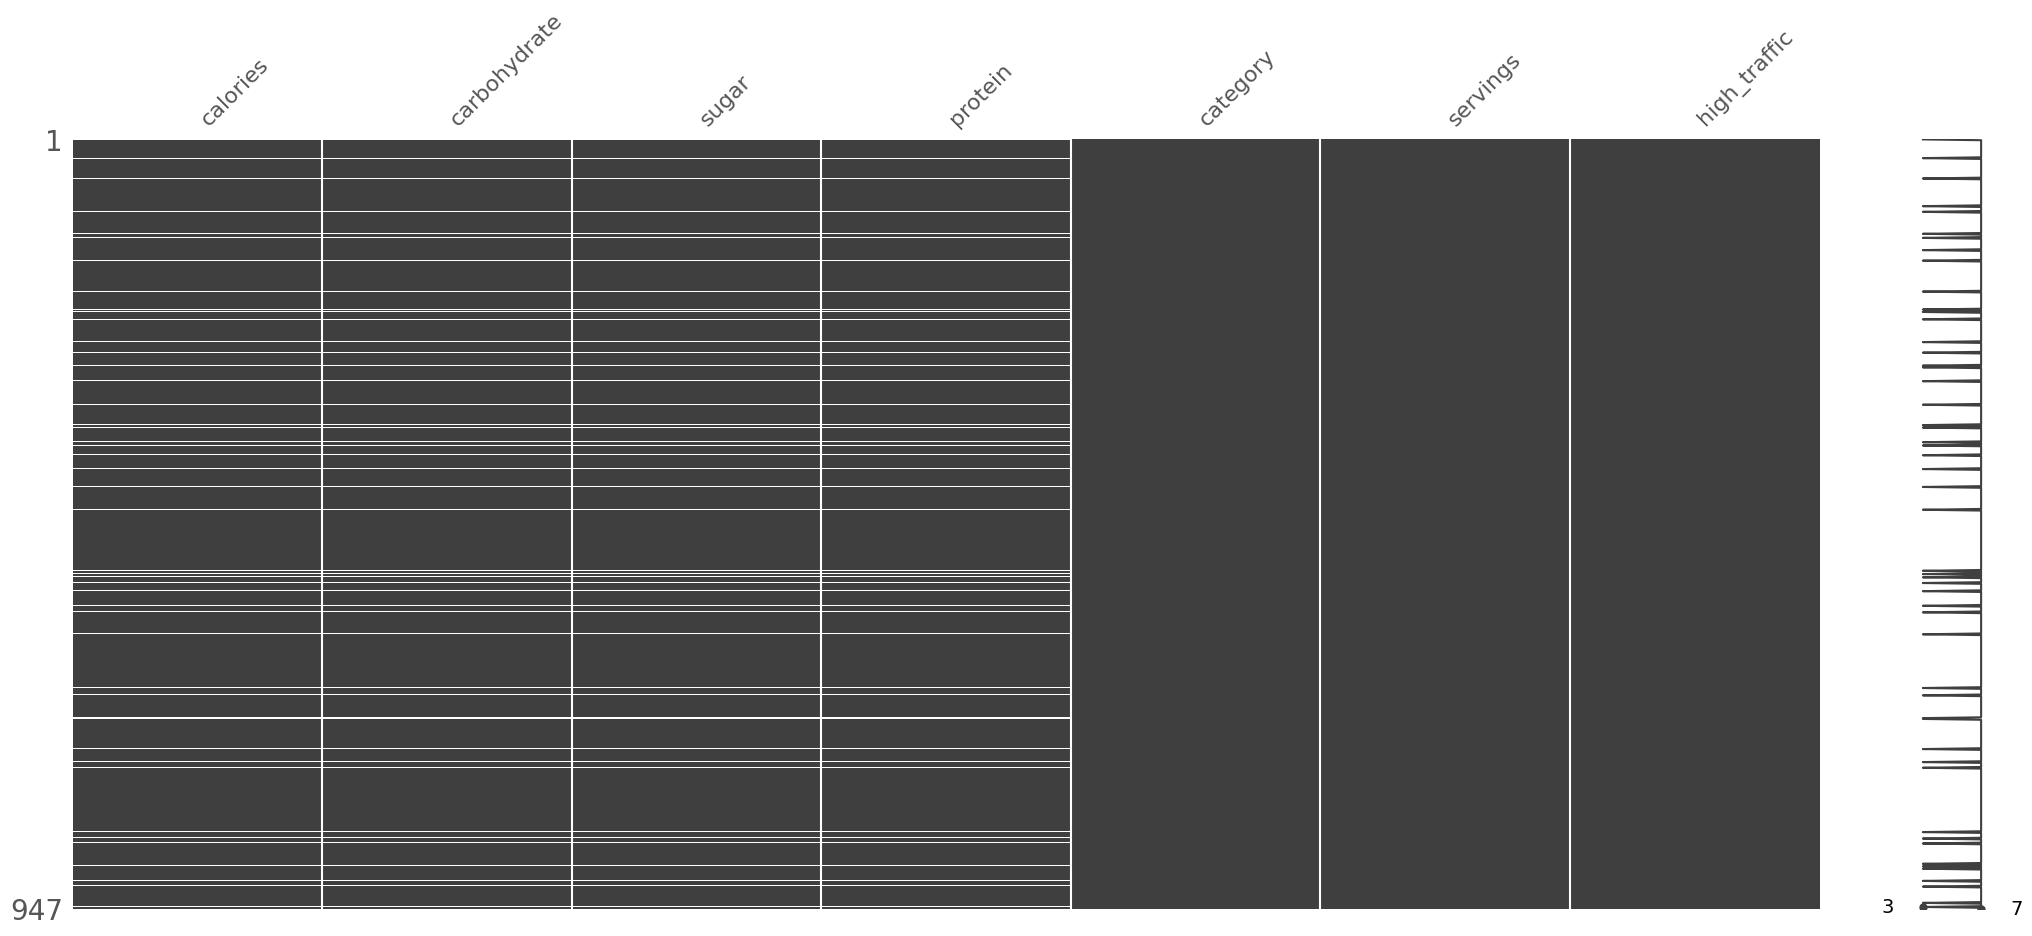

In [ ]:
# Utilizamos la libreria 'missingno' para visualizar los valores nulos en el Dataframe.
msno.matrix(df)

In [ ]:
# Como hemos observado, los valores nulos se encuentran ubicados en las columnas
# 'calories','carbohydrate','sugar' y 'protein'.
cols_na = ['calories','carbohydrate','sugar','protein']

# Para enriquecer el Dataframe y no perder filas, imputamos los valores nulos que encontramos en las
# columnas 'calories','carbohydrate','sugar' y 'protein' por la media de las columnas resultante de
# agrupar por la columna 'category'.
for col in cols_na:
    df[col] = df.groupby('category', observed=True)[col].transform(lambda x: x.fillna(x.mean()))

In [ ]:
# Observamos el Dataframe resultante después de aplicar estas modificaciones.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      947 non-null    float64 
 1   carbohydrate  947 non-null    float64 
 2   sugar         947 non-null    float64 
 3   protein       947 non-null    float64 
 4   category      947 non-null    category
 5   servings      947 non-null    category
 6   high_traffic  947 non-null    category
dtypes: category(3), float64(4)
memory usage: 33.2 KB


In [ ]:
# Estos pasos han limpiado y preparado tus datos para su posterior análisis y modelado.
# Miramos las primeras 5 filas del DataFrame.
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,577.808129,25.366226,6.091032,45.082355,Meat,6,1.0
1,35.480000,38.560000,0.660000,0.920000,Vegetable,4,1.0
2,914.280000,42.680000,3.090000,2.880000,Breakfast,1,0.0
3,97.030000,30.560000,38.630000,0.020000,Beverages,4,1.0
4,27.050000,1.850000,0.800000,0.530000,Beverages,4,0.0


## **Resúmen**

Hasta ahora hemos realizado una serie de pasos esenciales, como la eliminación de columnas innecesarias, la corrección de tipos de datos, la agrupación de categorías relacionadas y la imputación de valores faltantes.

Ahora bién, como ya sabemos el análisis de datos y la construcción de modelos de machine learning es un proceso iterativo. Luego, a continuación, continuamos explorando y refinando los datos disponibles para lograr unos mejores resultados.

## **Análisis Exploratorio**

Inicialmente no podemos afirmar que exista una correlación positiva o negativa entre las variables numéricas. En general, existen correlaciones débiles, siendo las más relevantes las proteínas y las calorías (0.178).

Se puede observar que las variables numéricas (sin considerar la variable 'servings') tienen una distribución significativa hacía la derecha, tal y como podemos apreciar en los histogramas, especialmente la columna 'protein'. Muchos algoritmos de Machine Learning necesitan que las variables numéricas tengan una distribución que se asemeje a una distribución gaussiana/normal. Esta es la razón por la que se realizó una transformación usando PowerTransformer de la librería sklearn. Una vez aplicado, los histogramas muestran la gran diferencia que supone el antes y el después de esta transformación (a la izquierda el antes y a la derecha el después).

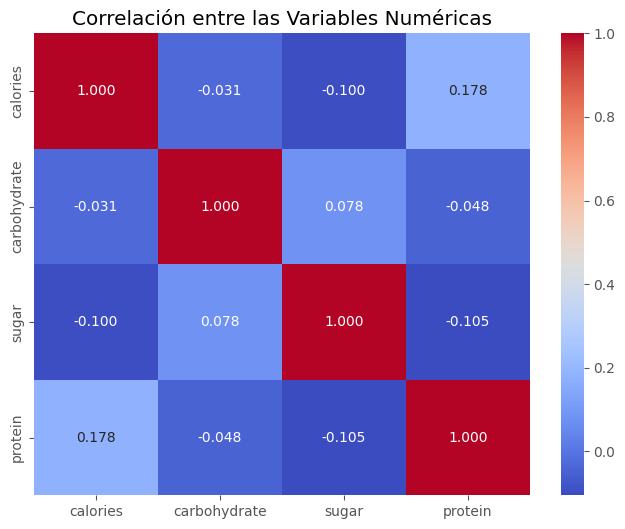

In [ ]:
# Usamos un gráfico de tipo Heatmap de la librería Seaborn para comprobar la correlación entre
# las columnas numéricas.

# Aumentamos el tamaño del gráfico para mostrar los valores de correlación de manera más clara
plt.figure(figsize=(8, 6))

# Calculamos la matriz de correlación
numeric = df[['calories','carbohydrate','sugar','protein']]
correlation_matrix = numeric.corr()

# Creamos el mapa de calor con anotaciones de valores
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)

# Establece el título
plt.title("Correlación entre las Variables Numéricas")

# Muestra el gráfico
plt.show()

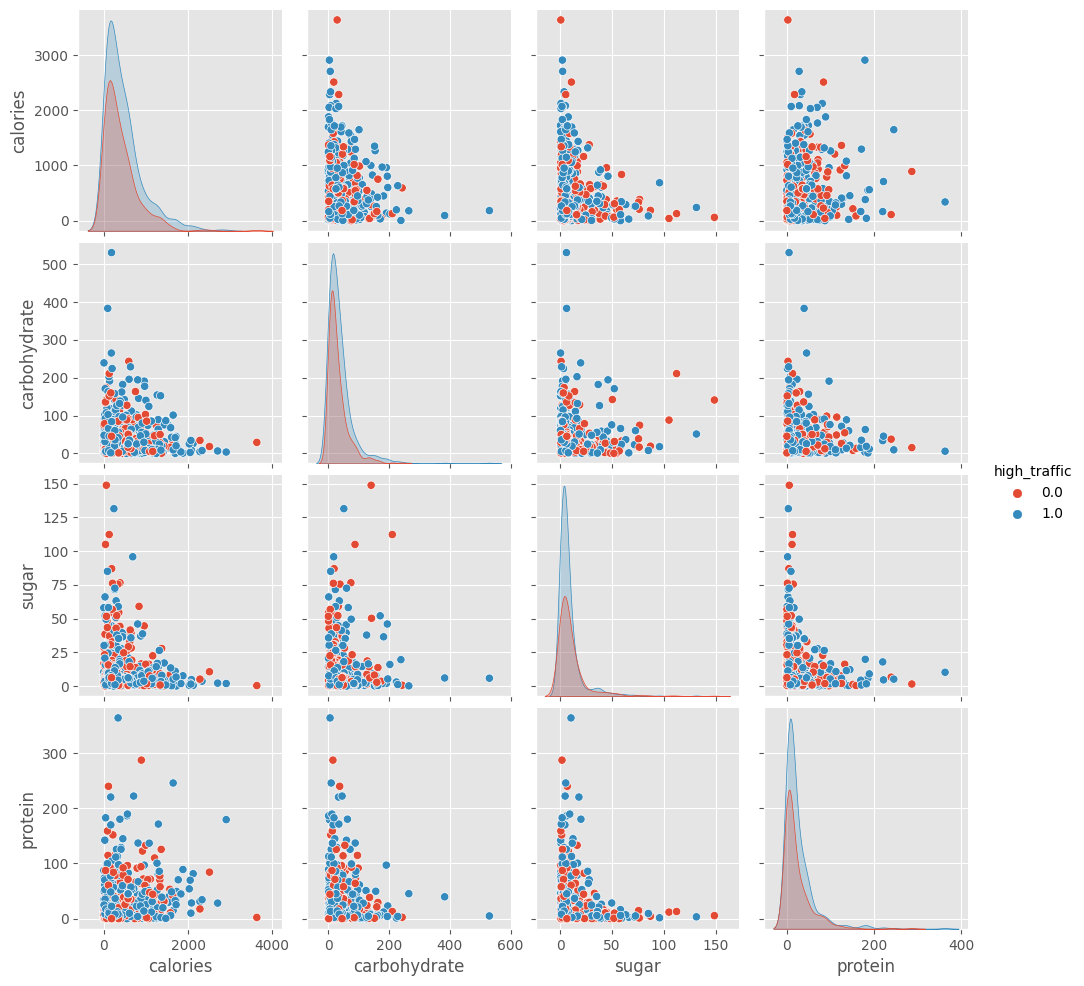

In [ ]:
# El gráfico pair plot de la librería Seaborn nos proporciona información sobre la distribución de los
# datos y mejora su visualización al incorporar el color para representar la distribución de las clases
# que estamos tratando de predecir en cada característica. Al incluir el color, podemos observar de
# manera efectiva dimensiones adicionales y patrones dentro del gráfico.

sns.pairplot(df.loc[:, ['calories', 'carbohydrate', 'sugar', 'protein', 'high_traffic']], hue='high_traffic');

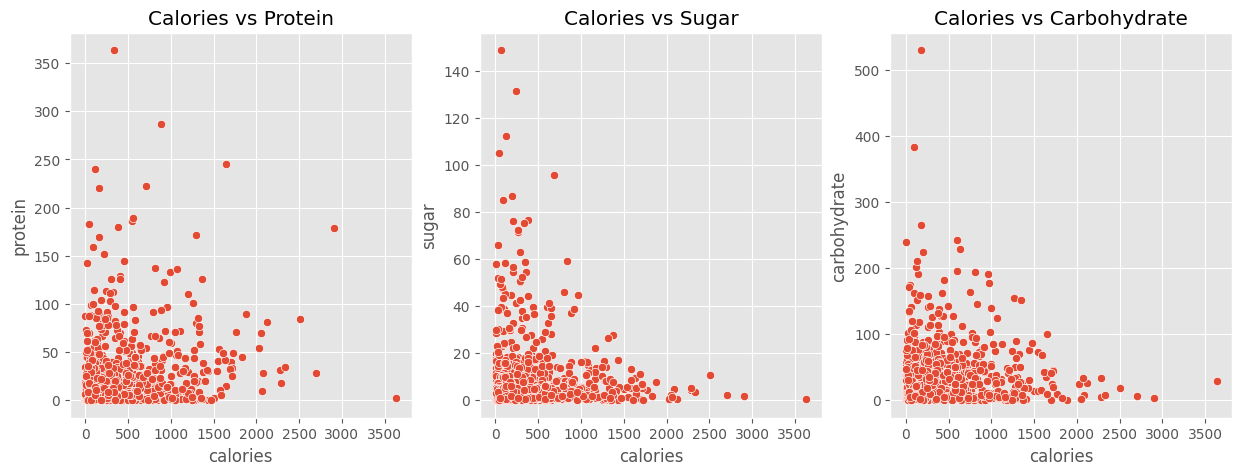

In [ ]:
# Utilizamos los scatter plots de Seaborn para comprobar la distribución de la columna 'calories' vs. las otras
# columnas numéricas ie, 'protein', 'sugar' y 'carbohydrate'.

fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.scatterplot(y=df['protein'],x=df['calories'],ax=axes[0]).set(title='Calories vs Protein')
sns.scatterplot(y=df['sugar'],x=df['calories'],ax=axes[1]).set(title='Calories vs Sugar')
sns.scatterplot(y=df['carbohydrate'],x=df['calories'],ax=axes[2]).set(title='Calories vs Carbohydrate');

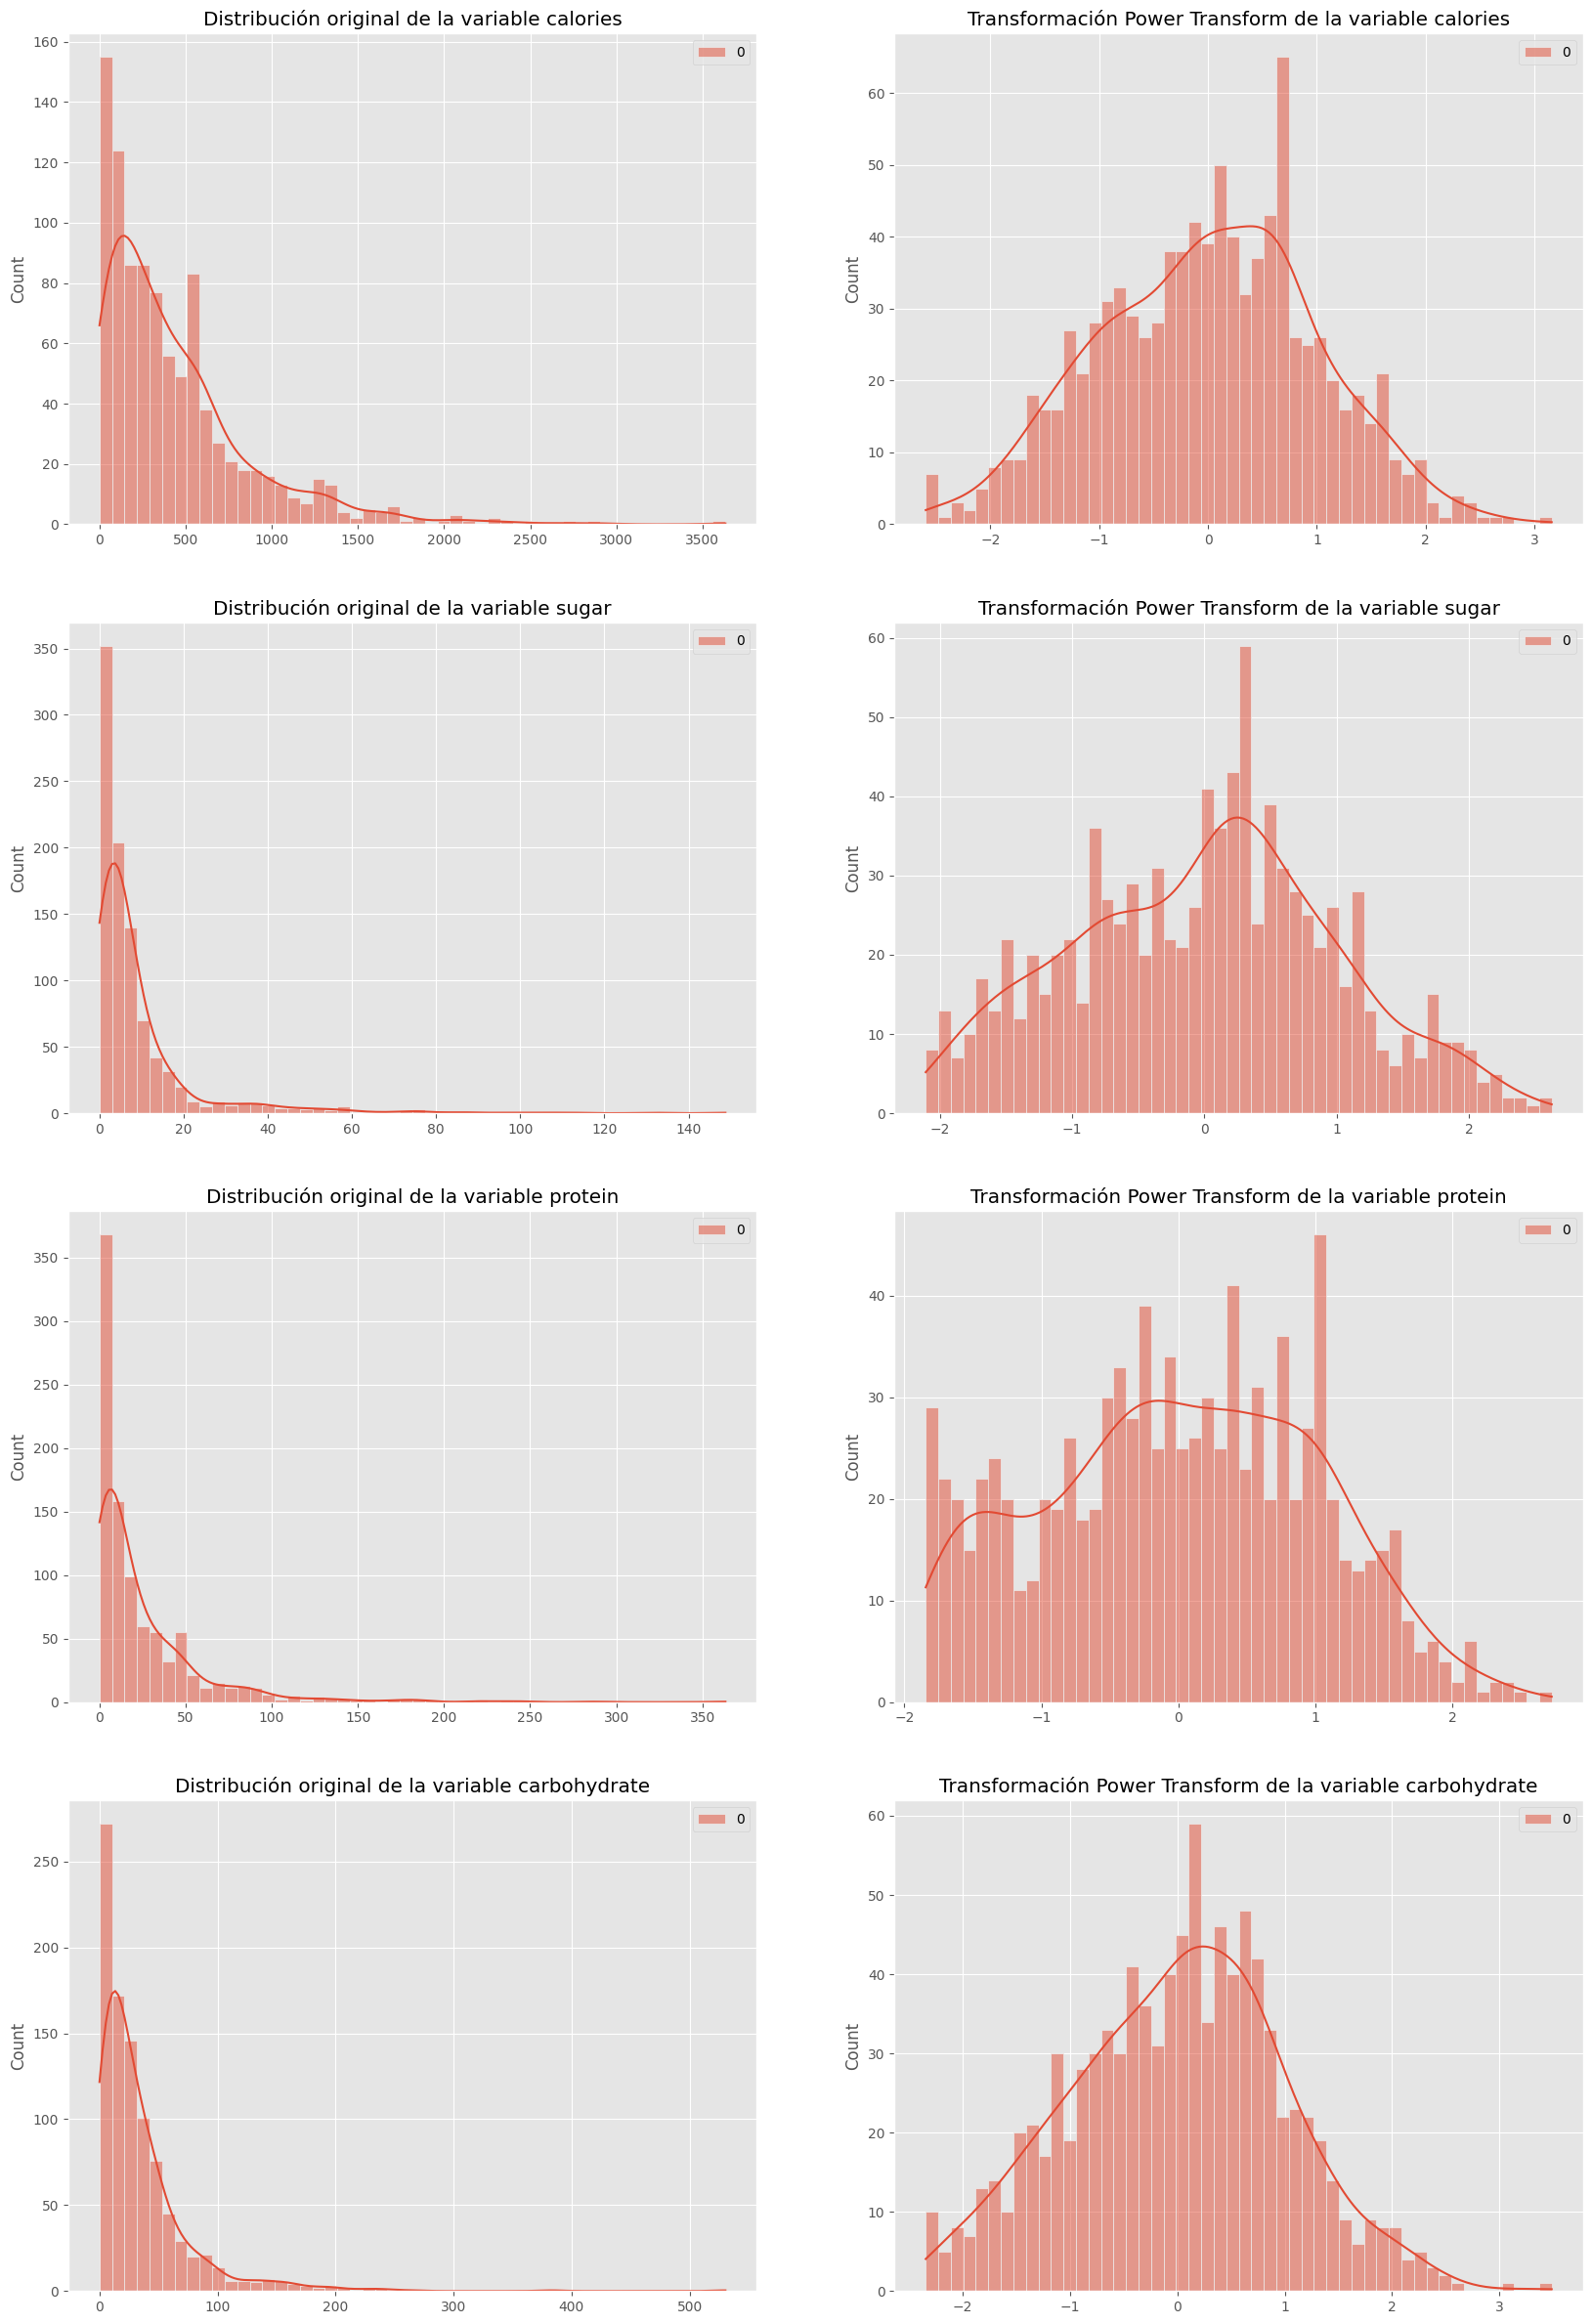

In [ ]:
# Ahora realizamos la transformacion de las variables aplicando PowerTransformer y 'normalizando'
# así su distribución.

cols = ['calories', 'sugar', 'protein', 'carbohydrate']

def test_transformers(columns):
    my_pt = PowerTransformer()
    fig = plt.figure(figsize=(20,30))
    j = 1
    for i in columns:
        array = np.array(df[i]).reshape(-1, 1)
        y = my_pt.fit_transform(array)

        plt.subplot(4,2,j)
        sns.histplot(array, bins = 50, kde = True)
        plt.title(f"Distribución original de la variable {i}")

        plt.subplot(4,2,j+1)
        sns.histplot(y, bins = 50, kde = True)
        plt.title(f"Transformación Power Transform de la variable {i}")
        j += 2

# Mostramos las distribuciones antes y después de aplicar el Power Transform
test_transformers(cols)

## **Resúmen**

En esta parte del proyecto, he realizado un análisis exploratorio del dataset y he aplicado una transformación a las variables numéricas utilizando PowerTransformer de scikit-learn para poder ajustar sus distribuciones. Algunas observaciones clave:

1. **Matriz de Correlación**: He utilizado un heatmap para visualizar la correlación entre las variables numéricas. Esto es útil para identificar relaciones entre las variables. He observado que las correlaciones son en su mayoría débiles, lo que indica que no hay una dependencia lineal fuerte entre estas variables. He comprobado que la mayor correlación se da entre las variables 'calories' y 'protein'.

2. **Gráfico Pair Plot**: El gráfico pair plot es una herramienta útil para explorar la distribución de datos y observar cómo se relacionan entre sí. Lo he utilizado para visualizar la distribución de las variables numéricas y cómo se relacionan con la variable objetivo 'high_traffic'. Esto puede ayudarnos a identificar patrones visuales en los datos.

3. **Scatter Plots**: La creación de scatter plots me ha permitido analizar la relación entre la variable 'calories' y las otras variables numéricas ('protein', 'sugar' y 'carbohydrate'). Estos gráficos proporcionan una representación visual de cómo estas variables se relacionan entre sí. Por ejemplo, he observado cómo la variable 'calories' se relaciona con las variables 'protein', 'sugar' y 'carbohydrate'.

4. **Transformación PowerTransformer**: He aplicado PowerTransformer a las variables numéricas para ajustar sus distribuciones. Esto es importante ya que muchos algoritmos de machine learning funcionan mejor con datos que siguen una distribución gaussiana o normal. La comparación de las distribuciones antes y después de la transformación muestra claramente cómo esta técnica puede mejorar la simetría de los datos.

En general, este análisis exploratorio es esencial para comprender los datos y cómo se distribuyen. La transformación de las variables numéricas es un paso importante para preparar los datos para la construcción de modelos de machine learning.

## Desarrollo del modelo

Nuestro objetivo es comprobar si podemos clasificar o no una receta en función del tráfico (high_traffic) que recibe (alto: 1 o bajo: 0), es decir lo que quiero es construir modelos de machine learning para predecir si una receta generará un tráfico alto o no. Por lo tanto, he considerado que estamos contemplando un caso de **clasificación** y algunos modelos comunes para la clasificación binaria incluyen la **Logistic Regression**, **Máquinas de Soporte Vectorial (SVM)**, **Bosques Aleatorios**, y otros. Utilizaré para ello como modelo base la **Logistic Regression**. La Logistic Regression es rápida de ejecutar y relativamente fácil de configurar.

Para evaluar los modelos, decidí utilizar las siguientes métricas: **accuracy, F1, precision and recall**. En las siguientes líneas, veremos cómo he preparado los datos para poder aplicar Machine Learning, el ajuste del modelo y los resultados obtenidos. Observaremos también qué tipos de recetas tienen éxito al aumentar el tráfico al sitio web.

He utilizado un flujo de trabajo que contiene una transformación a nivel de escala, una instancia del modelo y un selector para obtener las características más relevantes. He escogido también una lista de parámetros adaptados para la Logistic Regression.

Luego obtuve las métricas (F1, recall, precision, accuracy), grafiqué el peso de todas las características utilizadas y, finalmente, filtré los valores de predicción asociados a un alto tráfico con el fin de mostrar qué tipo de recetas tienen más popularidad y éxito, usando para ello un gráfico de barras que muestra las categorías más comunes.

### Modificando y transformando los datos: Preparación

Aplicaremos diferentes métodos de preparación y transformación al constatar que tenemos diferentes tipos de variables, por un lado tenemos variables numéricas y por otro categóricas.

Para las variables categóricas, utilizaremos la codificación one-hot, ya que proporciona una mayor precisión al aplicar los modelos.

En el caso de las variables numéricas y después de los resultados que hemos observado anteriormente, utilizaremos PowerTransformer.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Las columnas categóricas son
categoric_cols = ['category','servings']

# Instanciamos un objeto de la clase OneHotEncoder
ohe = OneHotEncoder()

# Transformación de las columnas categóricas
encoded_cols = ohe.fit_transform(df[categoric_cols])
encoded_df = pd.DataFrame(encoded_cols.toarray(),
                          columns=ohe.get_feature_names_out(categoric_cols))

df = pd.concat([df, encoded_df], axis=1)

# Eliminamos las columnas categóricas iniciales
df_enc = df.drop(categoric_cols, axis=1)

# Mostramos el Dataframe después de las transformaciones aplicadas sobre él
df_enc.head()

,calories,carbohydrate,sugar,protein,high_traffic,category_Beverages,category_Breakfast,category_Dessert,category_Lunch/Snacks,category_Meat,...,category_Breakfast,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Vegetable,servings_1,servings_2,servings_4,servings_6
0,577.808129,25.366226,6.091032,45.082355,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,35.480000,38.560000,0.660000,0.920000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,914.280000,42.680000,3.090000,2.880000,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,97.030000,30.560000,38.630000,0.020000,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,27.050000,1.850000,0.800000,0.530000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Ahora vamos a aplicar la transformación PowerTransformer
my_pt = PowerTransformer()
df_enc[['calories','protein','carbohydrate','sugar']] = my_pt.fit_transform(df_enc[['calories','protein','carbohydrate','sugar']])

# Creamos las variables correspondientes. En el axis=1 eliminamos la que hace referencia a
# 'high_traffic' y añadimos la 'y' que contiene a 'high_traffic'.
X = df_enc.drop('high_traffic', axis=1)
y = df_enc['high_traffic']

## **Resúmen**

De momento he intentado realizar una preparación lo más adecuada posible de los datos disponibles antes de aplicar modelos de machine learning para la clasificación binaria de recetas en función de su tráfico.

La codificación one-hot de las variables categóricas permite a los modelos trabajar con estas variables de manera más efectiva. Además, he aplicado la transformación PowerTransformer a las variables numéricas, que creo que es importante para asegurarme que sigan una distribución más cercana a una distribución normal, y por lo tanto esto puede beneficiar el rendimiento de algunos algoritmos de machine learning.

## Evaluando el modelo y sus resultados

Ahora observaremos que el modelo de Logistic Regression ha tenido buenos resultados.

Vemos algo más a fondo estos resultados:

- **Accuracy**: el modelo de Regresión Logística ha obtenido alrededor de un 73% de precisión (accuracy). Debemos tener en cuenta que estamos priorizando la precisión sobre la exactitud.
- **Precision**: el modelo de Regresión Logística obtuvo cerca del 79%.
- **Recall**: el modelo de Regresión Logística ha obtenido alrededor del 80%.
- **F1**: al ser la media entre las métricas precision y recall obtiene un valor un poco superior al 80%.

###**Aplicamos el modelo de Logistic Regression**

Consideraciones a tener en cuenta.

####**GridSearchCV**

GridSearchCV es una técnica utilizamos para buscar los mejores hiperparámetros asociados a un modelo de machine learning. Los hiperparámetros son configuraciones que pueden ser modificadas tales como la elección del kernel, la tasa de aprendizaje en redes neuronales o la profundidad del árbol en árboles de decisión.

El papel de GridSearchCV es vital para ayudar a encontrar la combinación óptima de hiperparámetros que maximice el rendimiento del modelo. Funciona de la siguiente manera:

1. Define un conjunto de hiperparámetros y sus valores posibles. Por ejemplo, los hiperparámetros podrían incluir el tipo de kernel, el valor de C (regularización), y otros parámetros específicos del modelo.

2. GridSearchCV realiza una búsqueda exhaustiva a través de todas las combinaciones posibles de valores de hiperparámetros. Puedes especificar qué métrica de evaluación deseas optimizar, como 'precision', 'recall', 'accuracy', etc.

3. Se entrena y evalúa el modelo con cada combinación de hiperparámetros utilizando una validación cruzada.

4. Al final, GridSearchCV devuelve la mejor combinación de hiperparámetros que maximiza la métrica de evaluación especificada.

Utilizaré GridSearchCV para encontrar la mejor combinación de hiperparámetros para el modelo de Regresión Linear.


####**Matriz de confusión**

La matriz de confusión es una herramienta fundamental para evaluar el rendimiento de un modelo de clasificación. Muestra la relación entre las predicciones del modelo y el valor real en el conjunto de datos de prueba.

La matriz de confusión se divide en cuatro partes:

1. **Verdaderos positivos (True Positives - TP)**: Representa los casos en los cuáles el modelo predijo correctamente el valor como positivo (high_traffic = 1) cuando el verdadero valor era positivo.

2. **Falsos positivos (False Positives - FP)**: Representa los casos en los que el modelo predijo incorrectamente el valor como positivo (high_traffic = 1) cuando el valor real era negativo (high_traffic = 0).

3. **Verdaderos negativos (True Negatives - TN)**: Representa los casos en los que el modelo predijo correctamente el valor como negativo (high_traffic = 0) cuando el valor real era negativo.

4. **Falsos negativos (False Negatives - FN)**: Representa los casos en los que el modelo predijo incorrectamente el valor como negativo (high_traffic = 0) cuando el valor real era positivo (high_traffic = 1).

La matriz de confusión nos permite evaluar aspectos como la precisión (accuracy), la precisión (precision) y el recall (también llamado sensibilidad). Estas métricas se calculan a partir de los valores obtenidos en la matriz de confusión y ayudan a entender el rendimiento del modelo en tareas de clasificación.

- **Precisión (Precision)**: Mide la proporción de casos positivos predichos **correctamente** en comparación con todos los casos positivos predichos. Se calcula como TP / (TP + FP).

- **Recall (Sensibilidad)**: Mide la proporción de casos positivos predichos **correctamente** en comparación con todos los casos positivos reales en el conjunto de datos. Se calcula como TP / (TP + FN).

- **Exactitud (Accuracy)**: Mide la proporción de predicciones **correctas** en comparación con todas las predicciones. Se calcula como (TP + TN) / (TP + TN + FP + FN).

La matriz de confusión y estas métricas son esenciales para identificar si el modelo tiende a cometer errores de falsos positivos o falsos negativos y ajustarlo en consecuencia.

Utilizaré la matriz de confusión para visualizar cómo se distribuyen las predicciones del modelo de Regresión Lineal en comparación con los valores  reales en los datos de prueba. Esto me permitirá evaluar y comprender mejor el rendimiento del modelo según verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Parámetros del mejor estimador: {'memory': None, 'steps': [('scaler', StandardScaler()), ('selector', SelectKBest(k='all')), ('classifier', LogisticRegression(C=1, solver='saga'))], 'verbose': False, 'scaler': StandardScaler(), 'selector': SelectKBest(k='all'), 'classifier': LogisticRegression(C=1, solver='saga'), 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'selector__k': 'all', 'selector__score_func': <function f_classif at 0x781da10ef490>, 'classifier__C': 1, 'classifier__class_weight': None, 'classifier__dual': False, 'classifier__fit_intercept': True, 'classifier__intercept_scaling': 1, 'classifier__l1_ratio': None, 'classifier__max_iter': 100, 'classifier__multi_class': 'auto', 'classifier__n_jobs': None, 'classifier__penalty': 'l2', 'classifier__random_state': None, 'classifier__solver': 'saga', 'classifier__tol': 0.0001, 'classifier__verbose': 0, 'classifier__warm_start': False}
Resultados de la Regresión Logística:
Accuracy: 0.7315789473684211
F1:

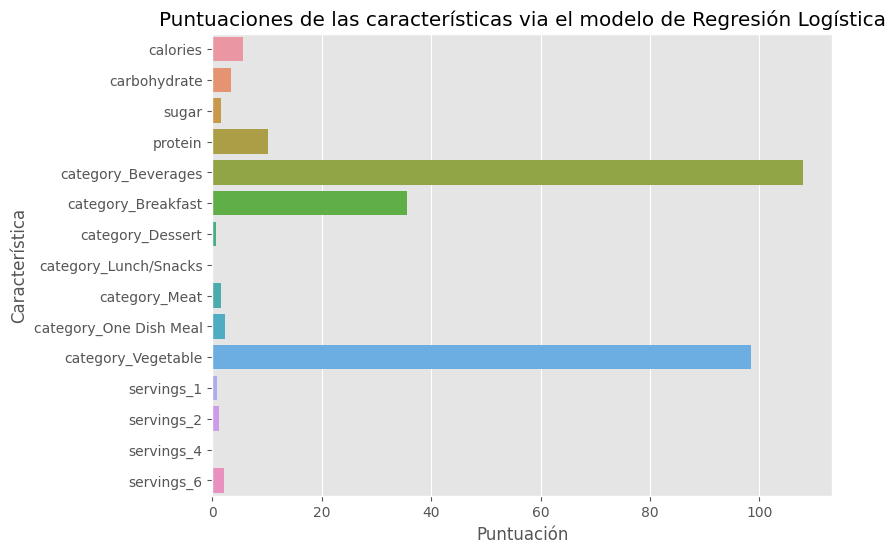

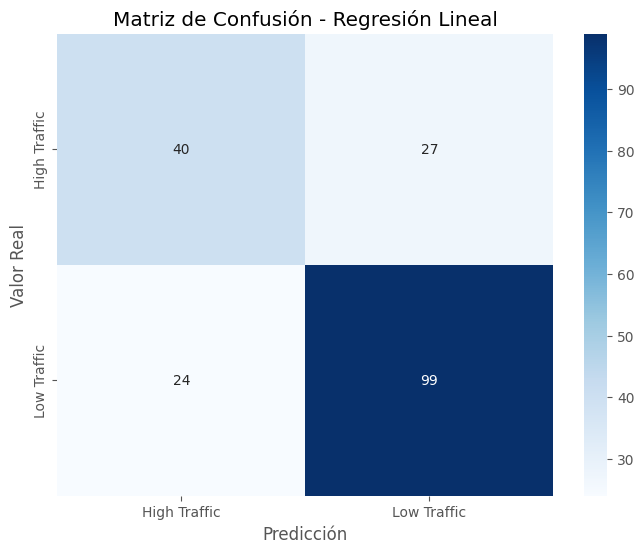

In [ ]:
from sklearn.linear_model import LogisticRegression

# Separacion de los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

# Definimos el flujo o pipeline que usamos para aplicar el modelo
my_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(f_classif)),
    ('classifier', LogisticRegression())
])

# Definición de los hyperparametros para GridSearchCV
parameters = {
    'selector__k': ['all'],
    'classifier__C': [0.001, 0.1, 1, 10, 100, 1000],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear','saga']
}

# Instanciamos GridSearchCV con 5-fold cross-validation
my_grid_search = GridSearchCV(
                  my_pipeline,
                  parameters,
                  cv=5,
                  scoring='precision'
                )

# Con los datos de train realizamos un fit de GridSearchCV
my_grid_search.fit(X_train, y_train)

# Obtenemos el mejor estimador
my_best_estimator = my_grid_search.best_estimator_

# Mostramos los parámetros del estimador obtenido
print("Parámetros del mejor estimador:", my_best_estimator.get_params())

# Ahora vamos a evaluar el estimador usando los datos de test
y_prediccion_proba = my_best_estimator.predict_proba(X_test)
my_threshold = 0.6
y_prediccion = (y_prediccion_proba[:,1] > my_threshold).astype(int)

accuracy = accuracy_score(y_test, y_prediccion)
f1 = f1_score(y_test, y_prediccion)
precision = precision_score(y_test, y_prediccion)
recall = recall_score(y_test, y_prediccion)

# Mostramos los resultados de la Regresión Logística
print('Resultados de la Regresión Logística:')
print("Accuracy:", accuracy)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Obtenemos los indices de las recetas con 'high_traffic' respecto a los datos de test
my_high_traffic_indexs = np.where(y_prediccion == 1)[0]

# Conseguimos las recetas (recipes) que tienen un 'high_traffic' alto
my_high_traffic_recipes = X_test.iloc[my_high_traffic_indexs]

# Vamos a graficar las puntuaciones respecto a las características seleccionadas
selector = my_best_estimator.named_steps['selector']
selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = X.columns[selected_indices]

# Mostramos un gráfico de tipo bar plot con las puntuaciones respecto a las características estudidadas
plt.figure(figsize=(8, 6))
sns.barplot(x=selected_scores, y=selected_features)
plt.title('Puntuaciones de las características via el modelo de Regresión Logística')
plt.xlabel('Puntuación')
plt.ylabel('Característica')
plt.show()

from sklearn.metrics import confusion_matrix

# Matriz de confusión del modelo SVM
lr_confusion = confusion_matrix(y_test, y_prediccion)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))

sns.heatmap(
    lr_confusion,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['High Traffic', 'Low Traffic'],
    yticklabels=['High Traffic', 'Low Traffic']
)

plt.title("Matriz de Confusión - Regresión Lineal")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

####**Explicación**

Vamos a explicar que es lo que nos indican los valores obtenidos en la matriz de confusión:

- **40 Verdaderos Positivos (True Positives - TP)**: Estos son casos en los que el modelo ha predicho correctamente un valor positivo (high_traffic = 1) y su valor real era también positivo. En otras palabras, el modelo identificó correctamente 40 ejemplos.

- **99 Verdaderos Negativos (True Negatives - TN)**: Estos son casos en los que el modelo ha predicho correctamente el valor negativo (high_traffic = 0) y el valor real era negativo (high_traffic = 0). El modelo identificó correctamente 99 ejemplos.

- **27 Falsos Positivos (False Positives - FP)**: Estos son casos en los que el modelo ha predicho incorrectamente un valor positivo (high_traffic = 1) cuando el valor real era negativo (high_traffic = 0). El modelo cometió 27 errores al clasificar estos ejemplos.

- **24 Falsos Negativos (False Negatives - FN)**: Estos son casos en los que el modelo ha predicho incorrectamente un valor negativo (high_traffic = 0) cuando el valor real era positivo (high_traffic = 1). El modelo cometió 24 errores al clasificar estos ejemplos.

En resumen, estos valores indican cómo se ha comportado el modelo de regresión lineal que hemos implementado para realizar una clasificación binaria. El modelo identificó correctamente 40 ejemplos como positivos, 99 ejemplos como negativos, cometió 27 errores al clasificar negativos como positivos y cometió 24 errores al clasificar positivos como negativos. Estos valores son esenciales para calcular métricas como precisión, recall, exactitud y F1-score, que proporcionan una visión más completa del rendimiento del modelo.

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'category_Meat'),
  Text(1, 0, 'category_Vegetable'),
  Text(2, 0, 'category_One Dish Meal'),
  Text(3, 0, 'category_Dessert'),
  Text(4, 0, 'category_Lunch/Snacks'),
  Text(5, 0, 'category_Beverages'),
  Text(6, 0, 'category_Breakfast')])

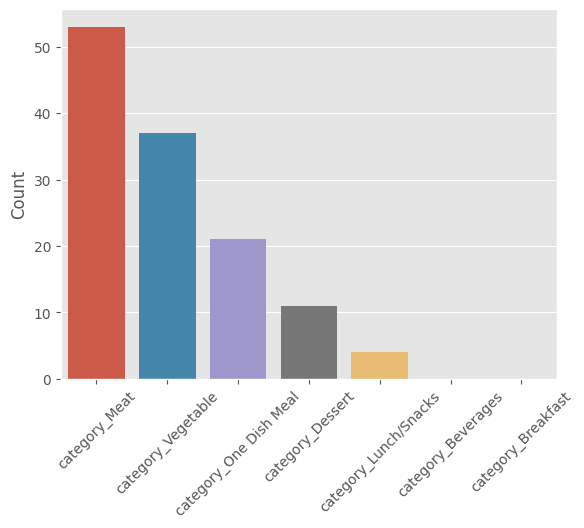

In [ ]:
# Columnas categóricas
df_categoricas = pd.DataFrame(
                    my_high_traffic_recipes.filter(like='category')
                                           .sum()
                                           .sort_values(ascending=False)
                )

df_categoricas.rename(columns={0:'Count'}, inplace=True)

# Mostramos la media de las categorías
sns.barplot(x=df_categoricas.index, y='Count', data=df_categoricas)
plt.xticks(rotation=45)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'servings_4'),
  Text(1, 0, 'servings_6'),
  Text(2, 0, 'servings_1'),
  Text(3, 0, 'servings_2')])

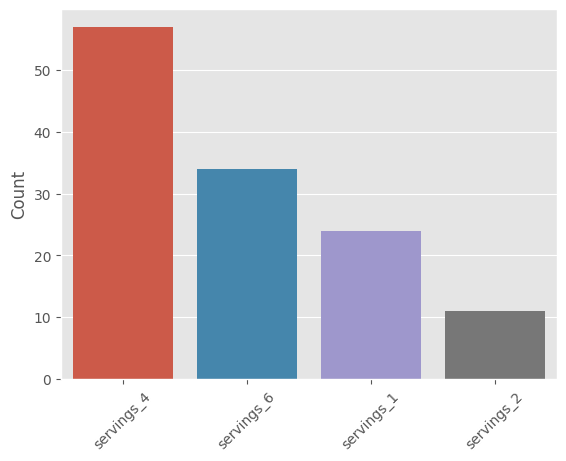

In [ ]:
# Columnas categóricas que referencian a 'servings'
df_categoricas = pd.DataFrame(
                    my_high_traffic_recipes.filter(like='servings')
                                           .sum()
                                           .sort_values(ascending=False)
                )

df_categoricas.rename(columns={0:'Count'}, inplace=True)

# Mostramos la media
sns.barplot(x=df_categoricas.index, y='Count', data=df_categoricas)
plt.xticks(rotation=45)

In [ ]:
# Mostramos las primeras 15 filas que contienen recetas con un alto 'high_traffic'
my_high_traffic_recipes.head(15)

,calories,carbohydrate,sugar,protein,category_Beverages,category_Breakfast,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,...,category_Breakfast,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Vegetable,servings_1,servings_2,servings_4,servings_6
191,0.763438,0.026470,1.786144,0.293981,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
142,-0.878671,0.169324,1.415928,-1.183086,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
702,0.535543,-1.125059,0.846604,0.800821,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
242,1.839798,1.162527,-0.886894,0.955123,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
710,-0.306516,-1.750015,0.016751,0.217193,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
428,1.923837,1.507962,-0.392515,0.208507,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
779,-1.890301,-0.536137,0.462115,0.646005,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
762,0.209599,-1.342623,1.201602,0.602817,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
582,0.390667,-0.075501,-0.043824,-0.485952,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
753,1.620401,0.114213,1.493760,1.547120,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


###**Modelo SVM**

El Support Vector Machine (Máquina de Vectores de Soporte) es un algoritmo de Machine Learning utilizado para tareas de clasificación y regresión. En el contexto de clasificación, SVM se utiliza para separar dos clases distintas de datos, lo que lo convierte en una herramienta eficaz para la clasificación binaria. Además, SVM ofrece un alto grado de precisión y es una excelente opción cuando la precisión es una prioridad.

Utilizaré SVM para clasificar recetas en función de su tráfico, es decir, para predecir si una receta generará un tráfico alto o bajo.

Resultados del modelo SVM:
Accuracy: 0.7578947368421053
F1: 0.8321167883211679
Precision: 0.7549668874172185
Recall: 0.926829268292683


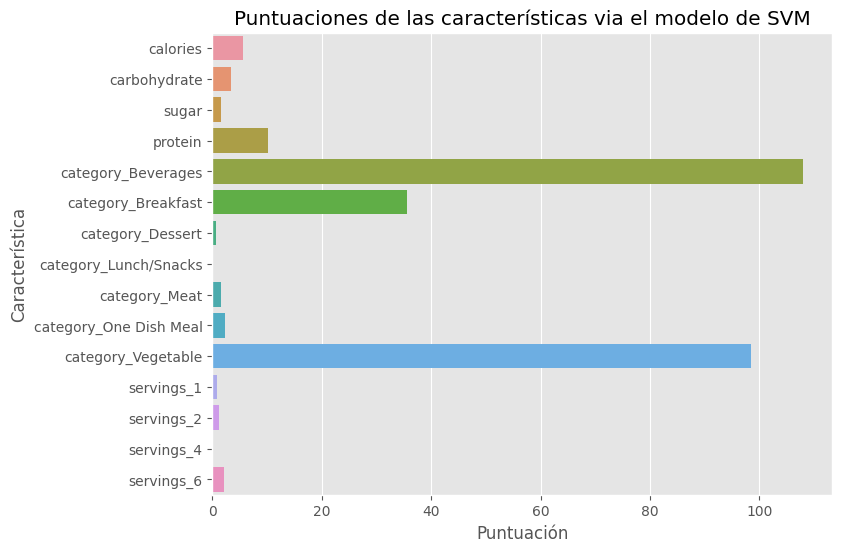

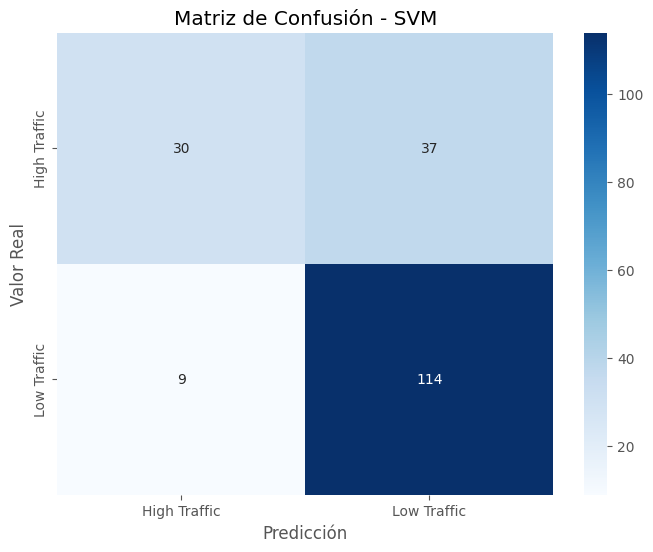

In [ ]:
from sklearn.svm import SVC

# Definir un flujo de trabajo para SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(f_classif)),
    ('classifier', SVC(probability=True))
])

# Definir parámetros para búsqueda en cuadrícula
svm_parameters = {
    'selector__k': ['all'],
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
}

# Instanciar GridSearchCV
svm_grid_search = GridSearchCV(svm_pipeline, svm_parameters, cv=5, scoring='precision')

# Entrenar el modelo SVM
svm_grid_search.fit(X_train, y_train)

# Evaluar el modelo SVM en el conjunto de prueba
svm_best_estimator = svm_grid_search.best_estimator_
svm_y_pred_proba = svm_best_estimator.predict_proba(X_test)
svm_y_pred = (svm_y_pred_proba[:, 1] > my_threshold).astype(int)

# Calcular métricas para el modelo SVM
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_f1 = f1_score(y_test, svm_y_pred)
svm_precision = precision_score(y_test, svm_y_pred)
svm_recall = recall_score(y_test, svm_y_pred)

# Mostrar resultados del modelo SVM
print('Resultados del modelo SVM:')
print("Accuracy:", svm_accuracy)
print("F1:", svm_f1)
print("Precision:", svm_precision)
print("Recall:", svm_recall)

# Vamos a graficar las puntuaciones respecto a las características seleccionadas
selector_s = svm_best_estimator.named_steps['selector']
selected_inds = selector_s.get_support(indices=True)
selected_scores_s = selector_s.scores_[selected_inds]
selected_features_s = X.columns[selected_inds]

# Mostramos un gráfico de tipo bar plot con las puntuaciones respecto a las características estudidadas
plt.figure(figsize=(8, 6))
sns.barplot(x=selected_scores_s, y=selected_features_s)
plt.title('Puntuaciones de las características via el modelo de SVM')
plt.xlabel('Puntuación')
plt.ylabel('Característica')
plt.show()

# Matriz de confusión del modelo SVM
svm_confusion = confusion_matrix(y_test, svm_y_pred)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))

sns.heatmap(
    svm_confusion,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['High Traffic', 'Low Traffic'],
    yticklabels=['High Traffic', 'Low Traffic']
)

plt.title("Matriz de Confusión - SVM")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

###**Comparación de los dos modelos, Regresión Linear vs SVC**

In [ ]:
# Mostramos los resultados de la Regresión Logística
print('Resultados de la Regresión Logística:')
print("Accuracy:", accuracy)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)

Resultados de la Regresión Logística:
Accuracy: 0.7315789473684211
F1: 0.7951807228915663
Precision: 0.7857142857142857
Recall: 0.8048780487804879


In [ ]:
# Mostrar resultados del modelo SVM
print('Resultados del modelo SVM:')
print("Accuracy:", svm_accuracy)
print("F1:", svm_f1)
print("Precision:", svm_precision)
print("Recall:", svm_recall)

Resultados del modelo SVM:
Accuracy: 0.7578947368421053
F1: 0.8321167883211679
Precision: 0.7549668874172185
Recall: 0.926829268292683


Resultados de la Regresión Logística:

- Accuracy: 0.7316
- F1: 0.7952
- Precision: 0.7857
- Recall: 0.8049

Resultados del modelo SVM:

- Accuracy: 0.7579
- F1: 0.8321
- Precision: 0.7550
- Recall: 0.9268

Veamos una comparativa de las diferentes métricas obtenidas según el modelo empleado:

1. Accuracy (Exactitud): El modelo SVM tiene una accuracy ligeramente superior (0.7579) en comparación con la Regresión Logística (0.7316). Esto significa que el modelo SVM clasifica correctamente una mayor proporción de ejemplos en el conjunto de test.

2. F1-Score: El F1-score combina precisión y recall en una sola métrica. El modelo SVM tiene un F1-score más alto (0.8321) en comparación con la Regresión Logística (0.7952), lo que indica un mejor equilibrio entre precisión y recall para este modelo.

3. Precision (Precisión): El modelo de Regresión Logística tiene una precisión ligeramente superior (0.7857) en comparación con el SVM (0.7550). Esto significa que cuando el modelo de Regresión Logística predice la clase positiva, tiende a ser más preciso.

4. Recall (Recuperación o Sensibilidad): El modelo SVM tiene un recall significativamente más alto (0.9268) en comparación con la Regresión Logística (0.8049). Esto significa que el SVM es más efectivo en identificar correctamente todos los ejemplos del valor real positivo en comparación con la Regresión Logística.

En general, los resultados sugieren que el modelo SVM supera a la Regresión Logística en términos de F1-score y recall, lo que indica que es mejor para identificar ejemplos con valor positivo. Sin embargo, la Regresión Logística tiene una precisión ligeramente superior, lo que significa que cuando predice un valor positivo, tiende a ser más precisa que el modelo SVM. La elección entre estos dos modelos depende del equilibrio deseado entre precisión y recall, así como de la importancia relativa de los falsos positivos y falsos negativos en el contexto específico de nuestro caso de estudio.